## Imports

In [6]:
from time import strftime
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm
from numba import jit, cuda, vectorize, njit
from google.colab import files

import cv2
import numpy as np
import math
import numba
import matplotlib.pyplot as plt

## Downloading Datasets

In [7]:
import wget
import zipfile

data = ['Art', 'Books', 'Laundry', 'Dolls', 'Reindeer', 'Moebius']

for scene in data:
    wget.download(f"https://vision.middlebury.edu/stereo/data/scenes2005/FullSize/zip-2views/{scene}-2views.zip")
    with zipfile.ZipFile(f"{scene}-2views.zip", 'r') as zip_ref:
        zip_ref.extractall('.')

100% [......................................................] 4573331 / 4573331

## Implementing BU and JBU

In [7]:
def gaussian(sigma):
    """
    Create a gaussian function with standard deviation sigma.
    Args:
        sigma: standard deviation
    Returns:
        Gaussian function g(x) with standard deviation sigma.
    """
    def g(x):
        a = 1 / (sigma * np.sqrt(2 * np.pi))
        exponent = (-1/2) * (x / sigma)**2
        return a * np.exp(exponent)

    return g


def make_border(img, width):
    """
    Extrapolate the border of an image for filtering.
    Implements the OpenCV BORDER_REFLECT_101 method for
    extrapolation.
    Args:
        img: the input image
        width: border width in pixels
    Returns:
        A copy of the image with an extrapolated border.
    """
    left_border = np.flip(img[:, 1:width+1], 1)
    right_border = np.flip(img[:, -width-1:-1], 1)

    img_h_bordered = np.hstack((left_border, img, right_border))

    top_border = np.flip(img_h_bordered[1:width+1, :], 0)
    bottom_border = np.flip(img_h_bordered[-width-1:-1, :], 0)

    img_bordered = np.vstack((top_border, img_h_bordered, bottom_border))

    return img_bordered


def calc_d_matrix(size):
    """
    Create a square matrix containing distances from the centre element.
    Args:
        size: number of rows/columns of matrix
    Returns:
        Matrix with each element equal to its distance from the centre.
    """
    if not size % 2:
        raise ValueError("nsize must be odd")

    m = np.zeros((size, size, 3))
    centre = size // 2

    for y in range(-centre, centre+1):
        for x in range(-centre, centre+1):
            m[y+centre][x+centre] = np.repeat(np.sqrt(x**2 + y**2), 3)

    return m


def calc_i_matrix(nhood):
    """
    Create a matrix containing intensity differences from the centre element.
    Args:
        nhood: local pixel neighbourhood to create matrix from
    Returns:
        Matrix with each element equal to the absolute difference in intensity
        from the centre element.
    """
    h, w = nhood.shape[0], nhood.shape[1]
    if h != w:
        raise ValueError("nhood should be square")
    elif not h % 2:
        raise ValueError("nhood should have odd dimensions")

    centre = nhood[h//2, h//2]
    i_matrix = np.array(nhood, dtype=int) - centre
    return i_matrix


def bilateral_filter(img, nsize, sigma_color, sigma_space):
    """
    Apply a bilateral filter to an image.
    Args:
        img: image to apply filter to
        nsize: diameter of pixel neighbourhood used to filter
        sigma_color: filter sigma in color space
        sigma_space: filter sigma in coordinate space
    Returns:
        Copy of the image with a bilateral filter applied to it.
    """
    if not nsize % 2:
        raise ValueError("nsize must be odd")

    nw = nsize // 2
    d_matrix = calc_d_matrix(nsize)

    img_w, img_h = img.shape[1], img.shape[0]

    src = make_border(img, nw)
    dst = np.empty(img.shape, img.dtype)

    g_color = gaussian(sigma_color)
    g_space = gaussian(sigma_space)

    d_matrix = g_space(d_matrix)

    for y in range(img_h):
        for x in range(img_w):
            centre = img[y, x]
            nhood = src[y:y + 2*nw + 1, x:x + 2*nw + 1]
            i_matrix = calc_i_matrix(nhood)
            i_matrix = g_color(i_matrix)

            p = np.multiply(d_matrix, i_matrix)

            numerator = np.sum(np.multiply(p, nhood), axis=(0, 1))
            denominator = np.sum(p, axis=(0, 1))

            response = numerator/denominator
            dst[y, x] = response

    return np.array(dst, dtype=img.dtype)


def joint_bilateral_filter(flash_img, noflash_img, nsize,
                           sigma_color, sigma_space):
    """
    Apply a joint bilateral filter to a pair of images, one taken with flash
    and the other without.
    Args:
        flash_img: image taken with flash
        noflash_img: image taken without flash
        nsize: diameter of pixel neighbourhood used to filter
        sigma_color: filter sigma in color space
        sigma_space: filter sigma in coordinate space
    Returns:
        An image combining the colour attributes from the image without flash
        and the fine details of the image with flash.
    """
    if not nsize % 2:
        raise ValueError("nsize must be odd")

    nw = nsize // 2
    d_matrix = calc_d_matrix(nsize)

    img_w, img_h = noflash_img.shape[1], noflash_img.shape[0]

    src_noflash = make_border(noflash_img, nw)
    src_flash = make_border(flash_img, nw)
    dst = np.empty(noflash_img.shape, noflash_img.dtype)

    g_color = gaussian(sigma_color)
    g_space = gaussian(sigma_space)

    d_matrix = g_space(d_matrix)

    for y in range(img_h):
        for x in range(img_w):
            centre = noflash_img[y, x]
            nhood_noflash = src_noflash[y:y + 2*nw + 1, x:x + 2*nw + 1]
            nhood_flash = src_flash[y:y + 2*nw + 1, x:x + 2*nw + 1]

            i_matrix_flash = calc_i_matrix(nhood_flash)
            i_matrix_flash = g_color(i_matrix_flash)

            p = np.multiply(d_matrix, i_matrix_flash)

            numerator = np.sum(np.multiply(p, nhood_noflash), axis=(0, 1))
            denominator = np.sum(p, axis=(0, 1))

            response = numerator/denominator
            dst[y, x] = response

    return np.array(dst, dtype=noflash_img.dtype)

In [8]:
def plot_results(results):
    fig = plt.figure(figsize=(30, 30))

    for i, key in enumerate(results.keys()):

        fig.add_subplot(6, 3, i+1)
        
        plt.imshow(results[key][...,::-1]) # RGB-> BGR
        plt.axis('off')
        plt.title(key)
      
    return scene

def download_results(results):
    for i, key in enumerate(results.keys()):
        fig = plt.figure(figsize=(30, 30))
        plt.axis('off')
        plt.title(key)
        plt.imsave(f'{key}.png', results[key][...,::-1])
        files.download(f'{key}.png')

### Bilateral filter

In this test, we use an implemented bilateral filter with a combination of different parameters: 4 parameters for coloк sigma and 4 different parameters for space sigma. So we will see 16 images and can understand the difference between them

In [ ]:
def test_bilateral_filter():
    original_window = "Original Image"
    edited_window = "Edited Image"
    results = {}
    img = cv2.imread('Art/view5.png', cv2.IMREAD_COLOR)
    results[original_window] = img
    dst1 = cv2.bilateralFilter(img, 7, 100, 100)
    results[edited_window + ' OpenCV 100_100'] = dst1
    for radius in [7]:
        for color_sigma in [1, 5, 10, 100]:
            for space_sigma in [10, 20, 50, 100]:
                dst2 = bilateral_filter(img, radius, color_sigma, space_sigma)
                results[edited_window + f' implemented {color_sigma}_{space_sigma}'] = dst2

    return results


results = test_bilateral_filter()

'Moebius'

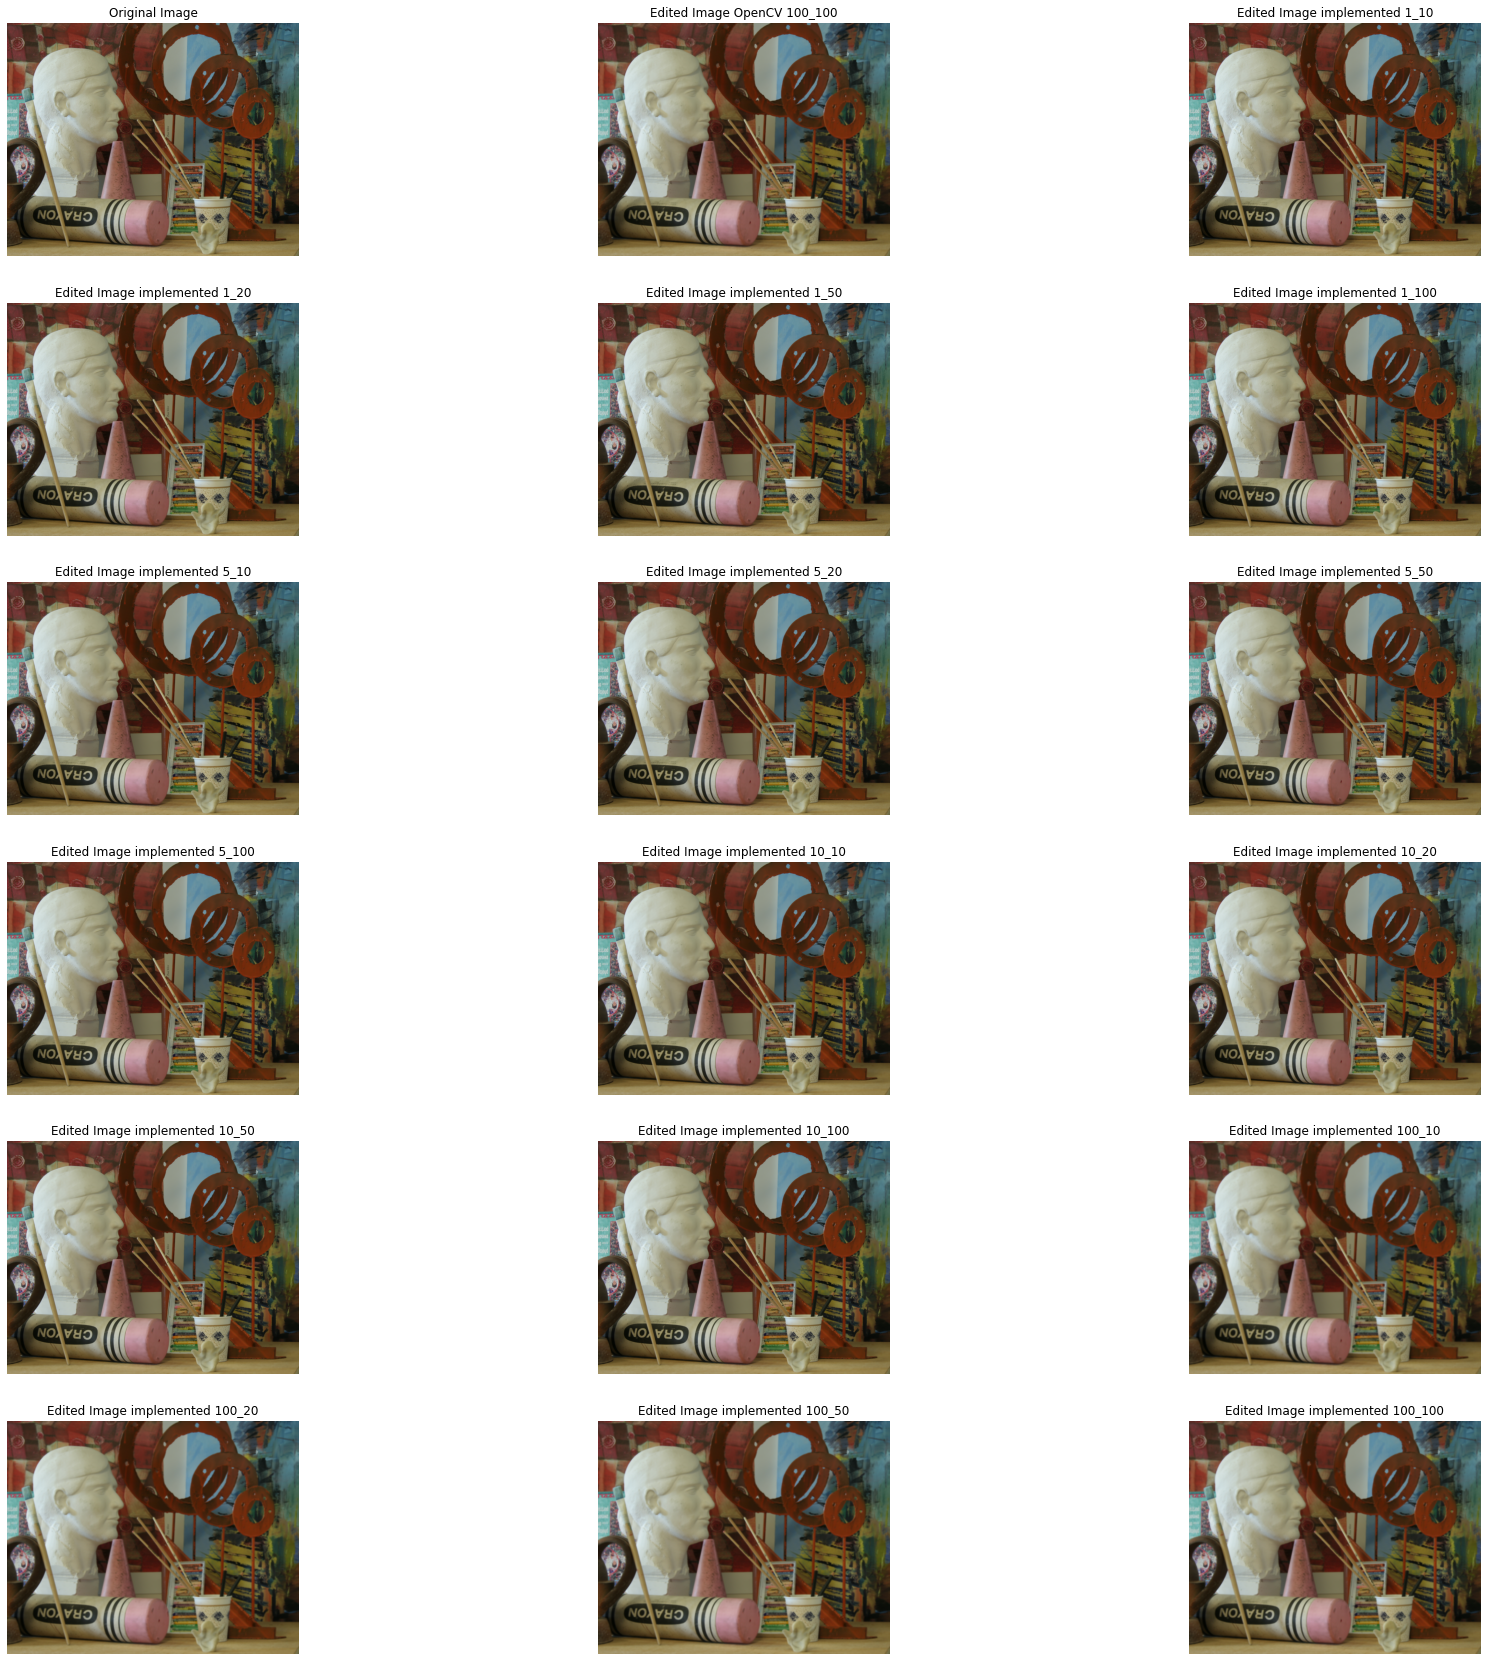

In [ ]:
plot_results(results)
# download_results(results)

As we can see, the larger the parameter values, the more blurry the image becomes

### JBU

For this test, we use depth and RGB images to get upsampling images.

In [ ]:
def test_joint_bilateral_filter():
    original_window = "Original Image"
    depth_window = "Depth Image"
    edited_window = "Edited Image"
    original_img = cv2.imread('Art/view1.png', cv2.IMREAD_COLOR)
    depth_img = cv2.imread('Art/disp1.png', cv2.IMREAD_COLOR)
    results = {}
    dst = joint_bilateral_filter(original_img, depth_img, 11, 100, 100)
    results[original_window] = original_img
    results[depth_window] = depth_img
    results[edited_window] = dst


    return results

results = test_joint_bilateral_filter()

  0%|          | 0/1110 [00:00<?, ?it/s]

'Moebius'

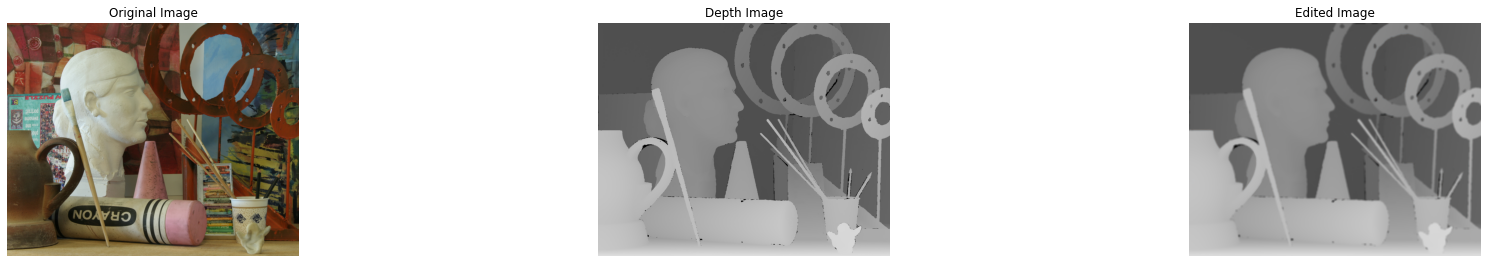

In [ ]:
plot_results(results)

In [ ]:
download_results(results)

In [9]:
def gasuss_noise(image, mean=0, var=0.001):
    ''' 
                 Add Gaussian noise
                 Mean: mean 
                 Var: Various
    '''
    image = np.array(image/255, dtype=float)
    noise = np.random.normal(mean, var ** 0.5, image.shape)
    out = image + noise
    if out.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.
    out = np.clip(out, low_clip, 1.0)
    out = np.uint8(out*255)
    #cv.imshow("gasuss", out)
    return out

I am implementing upsampling functions: 
- The original image is reduced in size and noise is added
- The square logarithm of the ratio of the original image and rgb sizes is considered
- In each iteration, I double the size of the original image and apply a JBU filter
- After all the iterations, I apply this filter again and we get the final image

In [11]:
def upsampling(scene):
    depth_img = cv2.imread(f'{scene}/disp1.png', cv2.IMREAD_COLOR)
    original_img = cv2.imread(f'{scene}/view1.png', cv2.IMREAD_COLOR)
    h, w, _ = depth_img.shape
    res = cv2.resize(depth_img, None, fx=0.125, fy=0.125)
    upsample_factor = math.ceil(math.log2(original_img.shape[0]/ res.shape[0]))
    for i in range(upsample_factor):
        res = cv2.resize(res, None, fx=2, fy=2)
        h, w, _ = res.shape
        original_img_res = cv2.resize(original_img, (w, h))
        res = joint_bilateral_filter(original_img_res, res, 5, 10, 50)
    h, w, _ = original_img.shape
    res = cv2.resize(res, (w, h))
    return joint_bilateral_filter(original_img, res, 5, 10, 50)

In [14]:
def upsampling_cv(scene, interpolation):
    depth_img = cv2.imread(f'{scene}/disp1.png', cv2.IMREAD_COLOR)
    original_img = cv2.imread(f'{scene}/view1.png', cv2.IMREAD_COLOR)
    h, w, _ = depth_img.shape
    res = cv2.resize(depth_img, None, fx=0.125, fy=0.125)
    upsample_factor = math.ceil(math.log2(original_img.shape[0]/ res.shape[0]))
    for i in range(upsample_factor):
        res = cv2.resize(res, None, fx=2, fy=2,  interpolation = interpolation)
    return cv2.resize(res, (w, h),  interpolation = interpolation)

## Metrics

In [15]:
from skimage.metrics import structural_similarity

In [16]:
def rmse(org_img: np.ndarray, pred_img: np.ndarray, max_p=4095) -> float:
    """
    Root Mean Squared Error
    """

    org_img = org_img.astype(np.float32)

    dif = np.subtract(org_img, pred_img)
    m = np.mean(np.square( dif / max_p))
    s = np.sqrt(m)

    return s

In [17]:
def ssim(org_img: np.ndarray, pred_img: np.ndarray, max_p=4095) -> float:
    """
    Structural SIMularity index
    """

    return structural_similarity(org_img, pred_img, data_range=max_p, multichannel=True)

In [18]:
def psnr(org_img: np.ndarray, pred_img: np.ndarray, max_p=4095) -> float:
    """
    Peek Signal to Noise Ratio, implemented as mean squared error converted to dB.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    When using 12-bit imagery MaxP is 4095, for 8-bit imagery 255. For floating point imagery using values between
    0 and 1 (e.g. unscaled reflectance) the first logarithmic term can be dropped as it becomes 0
    """
    org_img = org_img.astype(np.float32)

    mse_bands = np.mean(np.square(org_img[:, :] - pred_img[:, :]))

    return 20 * np.log10(max_p) - 10. * np.log10(mse_bands)

## Reports

For each dataset, I create a report that contains:
- Calculation results after applying JBU filter and other methods
- Script execution time
- Metrics indicators for comparing the source and final image
- The images themselves, after applying various upsampling methods

In [71]:
import time
import pandas as pd

In [76]:
def plot_results(results):
    fig = plt.figure(figsize=(20, 20))

    for i, key in enumerate(results.keys()):

        fig.add_subplot(1, 6, i+1)
        
        plt.imshow(results[key][...,::-1], cmap='gray')
        plt.axis('off')
        plt.title(key)

In [25]:
pipeline = {
    'JBU': upsampling,
    'Nearest Neighbor': cv2.INTER_NEAREST,
    'Bicubic': cv2.INTER_CUBIC ,
    'Bilinear': cv2.INTER_LINEAR
}


def build_report(scene):
    report = {'algorithms': list(pipeline.keys()), 'computation_time': [], 'ssim': [], 'rmse': [], 'psnr': []}
    results = {}
    for key in pipeline.keys():
        start_time = time.time()
        if key == 'JBU':
            disp = pipeline[key](scene)
        else:
            disp = upsampling_cv(scene, pipeline[key])
        results[key] = disp
        report['computation_time'].append(str(time.time() - start_time)[:5])
        report['ssim'].append(ssim(cv2.imread(f'{scene}/disp1.png', cv2.IMREAD_COLOR), disp))
        report['rmse'].append(rmse(cv2.imread(f'{scene}/disp1.png', cv2.IMREAD_COLOR), disp))
        report['psnr'].append(psnr(cv2.imread(f'{scene}/disp1.png', cv2.IMREAD_COLOR), disp))
    plot_results(results)
    df = pd.DataFrame(report)
    df = df.style.set_caption(f"Report for {scene} scene")
    display(df)

,algorithms,computation_time,ssim,rmse,psnr
0,JBU,128.3,0.993551,0.002768,51.156352
1,Nearest Neighbor,0.050,0.991758,0.003071,50.255179
2,Bicubic,0.072,0.993278,0.002781,51.114914
3,Bilinear,0.060,0.993690,0.002691,51.401391


,algorithms,computation_time,ssim,rmse,psnr
0,JBU,128.7,0.991026,0.003286,49.665494
1,Nearest Neighbor,0.053,0.989516,0.003578,48.927496
2,Bicubic,0.072,0.990386,0.003419,49.323058
3,Bilinear,0.062,0.991303,0.003230,49.816237


,algorithms,computation_time,ssim,rmse,psnr
0,JBU,124.2,0.994288,0.002485,52.094379
1,Nearest Neighbor,0.050,0.993620,0.002703,51.362028
2,Bicubic,0.069,0.994421,0.002514,51.993508
3,Bilinear,0.058,0.994770,0.002392,52.425616


,algorithms,computation_time,ssim,rmse,psnr
0,JBU,128.9,0.991654,0.003047,50.322411
1,Nearest Neighbor,0.054,0.990695,0.003321,49.575806
2,Bicubic,0.074,0.991647,0.003146,50.043876
3,Bilinear,0.062,0.992225,0.002970,50.543766


,algorithms,computation_time,ssim,rmse,psnr
0,JBU,124.2,0.994276,0.002414,52.345237
1,Nearest Neighbor,0.051,0.993691,0.002632,51.594491
2,Bicubic,0.071,0.994619,0.002399,52.401192
3,Bilinear,0.059,0.994958,0.002304,52.751763


,algorithms,computation_time,ssim,rmse,psnr
0,JBU,128.3,0.992279,0.002872,50.837493
1,Nearest Neighbor,0.052,0.991525,0.003103,50.164113
2,Bicubic,0.073,0.992384,0.002927,50.672712
3,Bilinear,0.063,0.992851,0.002783,51.108217


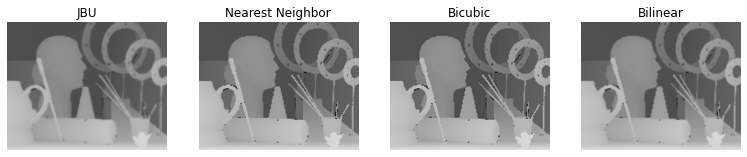

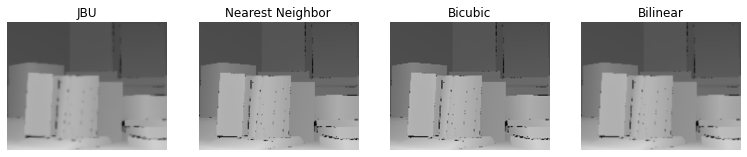

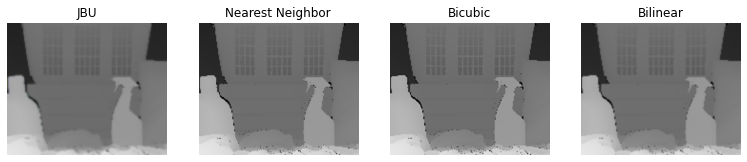

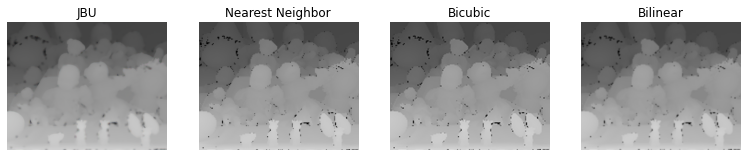

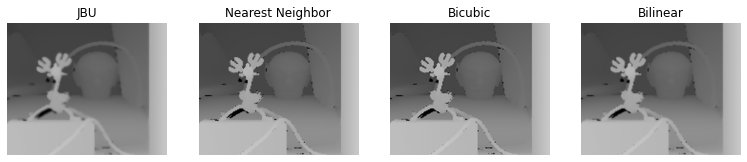

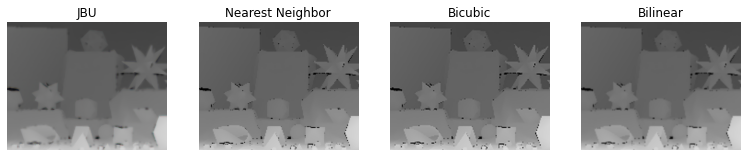

In [ ]:
for scene in data:
    build_report(scene)

## KITTI reports

In [19]:
import os

In [69]:
right_images = [f for f in os.listdir('./kitti_stereo/right')]
disp_images = [f for f in os.listdir('./kitti_stereo/disp')]

In [65]:
def upsampling_kitty(depth, orig):
    depth_img = cv2.imread(depth, cv2.IMREAD_COLOR)
    original_img = cv2.imread(orig, cv2.IMREAD_COLOR)
    h, w, _ = depth_img.shape
    res = cv2.resize(depth_img, None, fx=0.125, fy=0.125)
    upsample_factor = math.ceil(math.log2(original_img.shape[0]/ res.shape[0]))
    for i in range(upsample_factor):
        res = cv2.resize(res, None, fx=2, fy=2)
        h, w, _ = res.shape
        original_img_res = cv2.resize(original_img, (w, h))
        res = joint_bilateral_filter(original_img_res, res, 5, 10, 50)
    h, w, _ = original_img.shape
    res = cv2.resize(res, (w, h))
    return joint_bilateral_filter(original_img, res, 5, 10, 50)

In [73]:
def upsampling_kitty_cv(depth, orig, interpolation):
    depth_img = cv2.imread(depth, cv2.IMREAD_COLOR)
    original_img = cv2.imread(orig, cv2.IMREAD_COLOR)
    h, w, _ = depth_img.shape
    res = cv2.resize(depth_img, None, fx=0.125, fy=0.125)
    upsample_factor = math.ceil(math.log2(original_img.shape[0]/ res.shape[0]))
    for i in range(upsample_factor):
        res = cv2.resize(res, None, fx=2, fy=2,  interpolation = interpolation)
    return cv2.resize(res, (w, h),  interpolation = interpolation)

In [74]:
pipeline = {
    'JBU': upsampling_kitty,
    'Nearest Neighbor': cv2.INTER_NEAREST,
    'Bicubic': cv2.INTER_CUBIC ,
    'Bilinear': cv2.INTER_LINEAR
}


def build_report(depth, orig):
    report = {'algorithms': list(pipeline.keys()), 'computation_time': [], 'ssim': [], 'rmse': [], 'psnr': []}
    results = {}
    for key in pipeline.keys():
        start_time = time.time()
        if key == 'JBU':
            disp = pipeline[key](depth, orig)
        else:
            disp = upsampling_kitty_cv(depth, orig, pipeline[key])
        results[key] = disp
        report['computation_time'].append(str(time.time() - start_time)[:5])
        report['ssim'].append(ssim(cv2.imread(depth, cv2.IMREAD_COLOR), disp))
        report['rmse'].append(rmse(cv2.imread(depth, cv2.IMREAD_COLOR), disp))
        report['psnr'].append(psnr(cv2.imread(depth, cv2.IMREAD_COLOR), disp))
    plot_results(results)
    df = pd.DataFrame(report)
    df = df.style.set_caption(f"Report for {depth} scene")
    display(df)

/tmp/ipykernel_11004/2293015223.py:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return structural_similarity(org_img, pred_img, data_range=max_p, multichannel=True)


,algorithms,computation_time,ssim,rmse,psnr
0,JBU,24.77,0.982303,0.003521,49.066851
1,Nearest Neighbor,0.010,0.976470,0.003811,48.379350
2,Bicubic,0.010,0.976862,0.003712,48.607810
3,Bilinear,0.010,0.981314,0.003562,48.965354


,algorithms,computation_time,ssim,rmse,psnr
0,JBU,63.19,0.981550,0.003539,49.022522
1,Nearest Neighbor,0.010,0.977048,0.003783,48.444395
2,Bicubic,0.011,0.977180,0.003718,48.593950
3,Bilinear,0.011,0.981515,0.003575,48.935022


,algorithms,computation_time,ssim,rmse,psnr
0,JBU,63.14,0.968865,0.004647,46.657171
1,Nearest Neighbor,0.009,0.958144,0.005050,45.934472
2,Bicubic,0.011,0.959811,0.004912,46.175182
3,Bilinear,0.010,0.966697,0.004711,46.537406


,algorithms,computation_time,ssim,rmse,psnr
0,JBU,23.90,0.984742,0.003267,49.718258
1,Nearest Neighbor,0.010,0.979267,0.003558,48.974946
2,Bicubic,0.011,0.979624,0.003467,49.201212
3,Bilinear,0.010,0.983568,0.003327,49.558597


,algorithms,computation_time,ssim,rmse,psnr
0,JBU,23.78,0.974131,0.004285,47.361975
1,Nearest Neighbor,0.011,0.965038,0.004657,46.638765
2,Bicubic,0.011,0.965598,0.004535,46.867509
3,Bilinear,0.010,0.971730,0.004357,47.216604


,algorithms,computation_time,ssim,rmse,psnr
0,JBU,24.06,0.971743,0.004534,46.870973
1,Nearest Neighbor,0.010,0.961719,0.004949,46.109486
2,Bicubic,0.010,0.963402,0.004786,46.400991
3,Bilinear,0.010,0.969475,0.004602,46.740994


,algorithms,computation_time,ssim,rmse,psnr
0,JBU,63.29,0.984320,0.003298,49.634786
1,Nearest Neighbor,0.010,0.979573,0.003554,48.986354
2,Bicubic,0.011,0.979724,0.003489,49.146810
3,Bilinear,0.011,0.983697,0.003344,49.514594


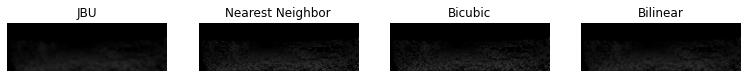

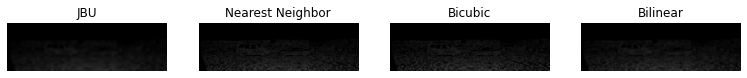

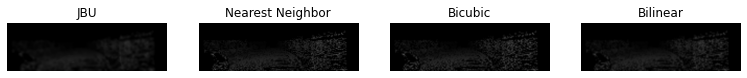

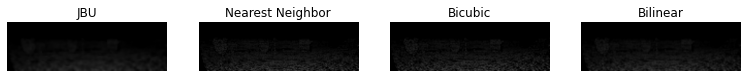

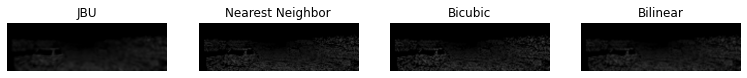

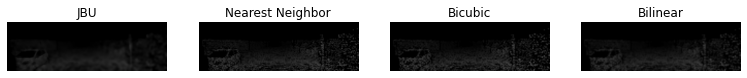

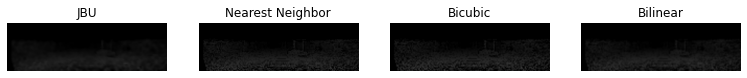

In [78]:
for index, file in enumerate(disp_images):
    build_report(f"./kitti_stereo/disp/{disp_images[index]}", f"./kitti_stereo/right/{right_images[index]}")